In [ ]:
%%shell
jupyter nbconvert --to html /content/P2.ipynb

[NbConvertApp] Converting notebook /content/P2.ipynb to html
[NbConvertApp] Writing 592007 bytes to /content/P2.html


# Data Science Portfolio - Part II (40 marks)

This question has been created to test your statistical analysis and programming knowledge in Python. 

You are given a `csv` file, which include various data entries for each football match in **English Premier League** during the 2020-2021 season. To name a few of these entries: date, referee name, number of goals, red cards, etc. The `csv` dataset you are provided contains one row per football match. The column names are abbreviations and given as: 

```
Div = League Division
Date = Match Date (dd/mm/yy)
Time = Time of match kick off
HomeTeam = Home Team
AwayTeam = Away Team
FTHG = Full Time Home Team Goals
FTAG = Full Time Away Team Goals
FTR = Full Time Result (H=Home Win, D=Draw, A=Away Win)
HTHG = Half Time Home Team Goals
HTAG = Half Time Away Team Goals
HTR = Half Time Result (H=Home Win, D=Draw, A=Away Win)
Referee = Match Referee
HS = Home Team Shots
AS = Away Team Shots
HST = Home Team Shots on Target
AST = Away Team Shots on Target
HF = Home Team Fouls Committed
AF = Away Team Fouls Committed
HC = Home Team Corners
AC = Away Team Corners
HY = Home Team Yellow Cards
AY = Away Team Yellow Cards
HR = Home Team Red Cards
AR = Away Team Red Cards
```


In this exercise, you are asked to perform a number of operations to:

 - perform statistical analysis of the data, and

 - gain insights from the data.

In [ ]:
# C21102236
# suggested imports
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy
from urllib import request
import scipy.stats as stats
from statsmodels import graphics
import arviz as az
import pymc3 as pm
from pymc3 import glm
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, RocCurveDisplay, auc, roc_curve
import seaborn as sns
sns.set_style(style="darkgrid", rc={"axes.facecolor": ".9", "grid.color": ".8"})
sns.set_palette(palette="deep")
sns_c = sns.color_palette(palette="deep")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
module_url = f"https://raw.githubusercontent.com/oktaykarakus/cmt309-portfolio/main/EPL_season-2021.csv"
module_name = module_url.split('/')[-1]
print(f'Fetching {module_url}')
with request.urlopen(module_url) as f, open(module_name,'w') as outf:
  a = f.read()
  outf.write(a.decode('utf-8'))

df = pd.read_csv('EPL_season-2021.csv')
df = df.fillna('')

Fetching https://raw.githubusercontent.com/oktaykarakus/cmt309-portfolio/main/EPL_season-2021.csv


In [ ]:
df.head(10)

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
0,E0,12/09/2020,12:30,Fulham,Arsenal,0,3,A,0,1,...,2,6,12,12,2,3,2,2,0,0
1,E0,12/09/2020,15:00,Crystal Palace,Southampton,1,0,H,1,0,...,3,5,14,11,7,3,2,1,0,0
2,E0,12/09/2020,17:30,Liverpool,Leeds,4,3,H,3,2,...,6,3,9,6,9,0,1,0,0,0
3,E0,12/09/2020,20:00,West Ham,Newcastle,0,2,A,0,0,...,3,2,13,7,8,7,2,2,0,0
4,E0,13/09/2020,14:00,West Brom,Leicester,0,3,A,0,0,...,1,7,12,9,2,5,1,1,0,0
5,E0,13/09/2020,16:30,Tottenham,Everton,0,1,A,0,0,...,5,4,15,7,5,3,1,0,0,0
6,E0,14/09/2020,20:15,Brighton,Chelsea,1,3,A,0,1,...,3,5,8,13,4,3,1,0,0,0
7,E0,14/09/2020,18:00,Sheffield United,Wolves,0,2,A,0,2,...,2,4,13,7,12,5,2,1,0,0
8,E0,19/09/2020,12:30,Everton,West Brom,5,2,H,2,1,...,7,4,9,11,11,1,1,0,0,1
9,E0,19/09/2020,15:00,Leeds,Fulham,4,3,H,2,1,...,7,6,13,18,5,3,1,2,0,0


## P2.1 - Data Pre-processing and Exploratory Analysis (11 marks)

In this question, your task is to use `pandas` and other required modules to preprocess the data frame, `df`. Preprocessing will include: add/remove/recode columns in `df`. In addition, to further explore the dataset, you need to produce a number of exploratory plots. 

#### P2.1.1 - Add Booking Points Columns (1 marks) 

Sometimes, in order to better analyse any given data set, one can create a new type of feature by combining two or more existing entries of the data frame. In this question, you are asked to create a function `add_booking_pts(df)` which creates two new columns of: **Home booking points (HBP)**, and **Away booking points (ABP)** by using four existing columns of HY, AY, HR, and AR.

The details of the function `add_booking_pts(df)` are given below:

 - Takes the data frame `df` as input.
 
 - For each match, number of yellow cards is weighted with 10 points, whilst the number of red cards is with 25 points. 
 
 - Basically, the function calculates HBP and ABP columns as
    - $HBP = 10\cdot HY + 25\cdot HR$
    - $ABP = 10\cdot AY + 25\cdot AR$
 
 - These newly created arrays are added to `df`, whilst removing the columns for HY, AY, HR, and AR.
 
 - Finally, the updated `df` is returned.

In [ ]:
def add_booking_pts(df):
    """
    Creates and calculates two new columns "HBP" and "ABP" based on the data from columns "HY","HR","AY" and "AR".
    Additionally, inserts these two new columns into the data frame and drops "HY","HR","AY" and "AR".

    Parameters
    ----------
    df : Pandas DATAFRAME
        dataframe that contains data from each football match, including, but not limited to columns "HY","HR","AY" and "AR".

    Returns
    -------
    df : Pandas DATAFRAME
        new dataframe containing two new columns "HBP" and "ABP", with "HY","HR","AY" and "AR" colums being dropped.

    """
    df["HBP"] = 10 * df.HY + 25 * df.HR # calculates home booking points(HBP) based on the formula $HBP = 10\cdot HY + 25\cdot HR$
    df["ABP"] = 10 * df.AY + 25 * df.AR # calculates away booking points(ABP) based on the formula $ABP = 10\cdot AY + 25\cdot AR$
    df = df.drop(["HY", "AY", "HR", "AR"], axis = 1) # drops columns "HY","HR","AY" and "AR" which are no longer needed
    return df
add_booking_pts(df)

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,HS,AS,HST,AST,HF,AF,HC,AC,HBP,ABP
0,E0,12/09/2020,12:30,Fulham,Arsenal,0,3,A,0,1,...,5,13,2,6,12,12,2,3,20,20
1,E0,12/09/2020,15:00,Crystal Palace,Southampton,1,0,H,1,0,...,5,9,3,5,14,11,7,3,20,10
2,E0,12/09/2020,17:30,Liverpool,Leeds,4,3,H,3,2,...,22,6,6,3,9,6,9,0,10,0
3,E0,12/09/2020,20:00,West Ham,Newcastle,0,2,A,0,0,...,15,15,3,2,13,7,8,7,20,20
4,E0,13/09/2020,14:00,West Brom,Leicester,0,3,A,0,0,...,7,13,1,7,12,9,2,5,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,E0,23/05/2021,16:00,Liverpool,Crystal Palace,2,0,H,1,0,...,19,5,5,4,10,8,14,1,20,20
376,E0,23/05/2021,16:00,Man City,Everton,5,0,H,2,0,...,21,8,11,3,8,10,7,5,20,20
377,E0,23/05/2021,16:00,Sheffield United,Burnley,1,0,H,1,0,...,12,10,3,3,11,1,8,9,30,10
378,E0,23/05/2021,16:00,West Ham,Southampton,3,0,H,2,0,...,14,17,7,5,5,9,2,3,0,30


#### P2.1.2 - Convert Table Colums into Digits (2 marks) 

When reading in the dataframe, one can see that it contains some textual data which will not be relevant for the numerical analyses in Question 1. Therefore, implement a function `convert_results(df)` 

1. (1 mark) to convert **half-time results (HTR)** and **full-time results (FTR)** into numerical data. The details of the function are given below: 
 
- HTR and FTR columns include string values of `'H'`, `'D'` and `'A'`. These string corresponds to the cases below:
    - `'H'`: Home team win

    - `'D'`: Draw

    - `'A'`: Away team win

- The function `convert_results(df)` will replace `'H'`, `'D'` and `'A'` values with `int` type values of of 1, 0, -1, respectively.

2. (1 mark) to convert **Time** column into `float` type values in interval of $[0, 24)$. Since an hour has 60 minutes, a 15-minute interval corresponds to quarter of an hour (i.e 0.25 hours). Considering this, some examples can be given:
 
- `'12.30'` will be `12.5`, or 
 
- `'18.15'` will be `18.25` or 
 
- `'17.00'` will be `17.0`
 
The function `convert_results(df)` should return the updated data frame `df`.

In [ ]:
def convert_results(df):
    """
    Replaces 'H', 'D' and 'A' values in columns "HTR" and "FTR" with int type values of of 1, 0, -1, respectively.
    Also converts "Time" column into float type values in interval of  [0,24), where 0 mins is represented as .0, 15 mins as 0.25, 30 min as 0.5 and so on

    Parameters
    ----------
    df : Pandas DATAFRAME
        dataframe that contains data from each football match, including, but not limited to columns "HTR", "FTR", and "Time".

    Returns
    -------
    df : Pandas DATAFRAME
        dataframe with updated columns "HTR", "FTR", and "Time".

    """
    count = 0 # count for the while loop
    while count < len(df.FTR): # iterate through all full time results
      if df.FTR[count] == "H": # if chosen full time result is a home win
        df.FTR[count] = 1 # change it to 1
      elif df.FTR[count] == "D": # if chosen full time result is a draw
        df.FTR[count] = 0 # change it to 0
      else: # if chosen full time result is an away win
        df.FTR[count] = -1 # change it to -1
      count += 1 # add 1 to a count to continue an iteration process
    count = 0 # reinitialize count for the next while loop
    while count < len(df.HTR): # iterate through all half time results
      if df.HTR[count] == "H": # if chosen half time result is a home win
        df.HTR[count] = 1 # change it to 1
      elif df.HTR[count] == "D": # if chosen half time result is a draw
        df.HTR[count] = 0 # change it to 0
      else: # if chosen full time result is an away win
        df.HTR[count] = -1 # change it to -1
      count += 1 # add 1 to a count to continue an iteration process
    count = 0 # reinitialize count for the next while loop
    while count < len(df.Time): # iterate through "Time" column
      x = float(df.Time[count].replace(":", ".")) # replace semicolumn in the chosen value in the "Time" column with a dot and make it a float type
      f = round(x - np.fix(x), 2) # extract a number after a decimal point and round it up up to 2 numbers after the decimal point 
      f = float(int(x) + f/60*100) # divide a number from the row above by 60 and multiply it by 100, add a number representing an hour and make it a float type
      df.Time[count] = f # change a chosen value in the "Time" column to value obtained in the row above
      count += 1 # add 1 to a count to continue an iteration process
    return df
convert_results(df)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to b

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,HF,AF,HC,AC,HY,AY,HR,AR,HBP,ABP
0,E0,12/09/2020,12.5,Fulham,Arsenal,0,3,-1,0,1,...,12,12,2,3,2,2,0,0,20,20
1,E0,12/09/2020,15.0,Crystal Palace,Southampton,1,0,1,1,0,...,14,11,7,3,2,1,0,0,20,10
2,E0,12/09/2020,17.5,Liverpool,Leeds,4,3,1,3,2,...,9,6,9,0,1,0,0,0,10,0
3,E0,12/09/2020,20.0,West Ham,Newcastle,0,2,-1,0,0,...,13,7,8,7,2,2,0,0,20,20
4,E0,13/09/2020,14.0,West Brom,Leicester,0,3,-1,0,0,...,12,9,2,5,1,1,0,0,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,E0,23/05/2021,16.0,Liverpool,Crystal Palace,2,0,1,1,0,...,10,8,14,1,2,2,0,0,20,20
376,E0,23/05/2021,16.0,Man City,Everton,5,0,1,2,0,...,8,10,7,5,2,2,0,0,20,20
377,E0,23/05/2021,16.0,Sheffield United,Burnley,1,0,1,1,0,...,11,1,8,9,3,1,0,0,30,10
378,E0,23/05/2021,16.0,West Ham,Southampton,3,0,1,2,0,...,5,9,2,3,0,3,0,0,0,30


#### P2.1.3 - Fair Play League Table (4 marks) 

Write a function `create_fair_play_table(df)` to depict a **barplot with horizontal bars** representing *total booking points*. The module `seaborn` and its corresponding methods and attributes must be used in this question.

Produce a bar for each team (use the HBP and ABP columns) and plot them in increasing order. The team with the top bar (*i.e.* lowest HBP+ABP) will represent the Fair Play League Champion. Also, print the statement below

```
The champions of the 2020-2021 Fair Play League is {locate the team here}.
```

![](https://drive.google.com/uc?export=view&id=11gYwhu-1D6dxEcmXK31pL5Zcop497w9i)

The champions of the 2020-2021 Fair Play League is Liverpool.


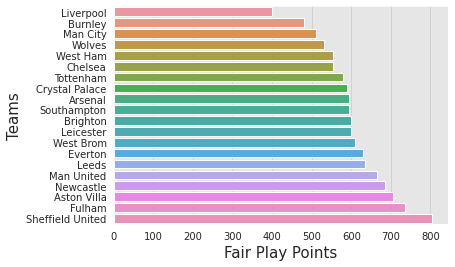

In [ ]:
def create_fair_play_table(df):
    """
    Depicts a barplot with horizontal bars representing total booking points for each team.
    Produces a bar for each team (uses the HBP and ABP columns) and plots them in an increasing order. 
    The team with the top bar (i.e. lowest HBP+ABP) represents the Fair Play League Champion. 
    Also prints the statement that includes Fair Play League Champion

    Parameters
    ----------
    df : Pandas DATAFRAME
        dataframe that contains data from each football match, including, but not limited to columns "HBP" and "ABP".

    Returns
    -------
    df_fp : Pandas DATAFRAME
        dataframe that contains each team's name with their corresponding fair play points.

    """
    x = {} # initialization of an empty dictionary to store teams' names and their fair play points in the future
    count = 0 # count for the while loop
    while count < len(df.HomeTeam): # iterate through "HomeTeam" column
      team = df.HomeTeam[count] # assign a chosen value of "HomeTeam" column to a variable team
      points = df.HBP[count] # assign a chosen value of "HBP" column to a variable points
      try: # try to add home booking points, captured in this iteration, to already stored points
        x[team] = x.get(team) + points
      except: # if there is an error, it means there are no points being stored previously, then create a new dictionary key and value 
        x[team] = points
      team = df.AwayTeam[count] # assign a chosen value of "AwayTeam" column to a variable team
      points = df.ABP[count] # assign a chosen value of "ABP" column to a variable points
      try: # try to add away booking points, captured in this iteration, to already stored points
        x[team] = x.get(team) + points
      except: # if there is an error, it means there are no points being stored previously, then create a new dictionary key and value
        x[team] = points
      count += 1 # add 1 to a count to continue an iteration process
    df_fp = pd.DataFrame(x.items(), columns = ["Teams","Fair Play Points"]) # create a datarame containing each team's name with their corresponding fair play points
    myplot = sns.barplot(x="Fair Play Points", y="Teams", data=df_fp.sort_values("Fair Play Points", ascending = True)) # create a plot of df_fp with df_fp's values being sorted in an increasing order
    myplot.set_xlabel("Fair Play Points", fontsize = 15) # set x-axis label and its fontsize
    myplot.set_ylabel("Teams", fontsize = 15) # set y-axis label and its fontsize
    print("The champions of the 2020-2021 Fair Play League is " + min(x, key=x.get) + ".") # print the statement that shows the winner of the Fair Play League
    return df_fp
df_fp = create_fair_play_table(df)

### P2.1.4 - Expected number of goals vs. Exact scores (4 marks) 

Expected number of goals (xG) is a predictive model used to assess every goal-scoring chance, and the likelihood of scoring. Nowadays, xG has a strong algorithm behind it, but in this example, we will assume two basic models to calculate the xG of any football team for any game:
 
 - $xG_1 = 0.1 \cdot S$
 
 - $xG_2 = 0.1 \cdot S + 0.05\cdot SoT$

where $S$ and $SoT$ is the total number of shoots and total shoots on target, respectively.

Write a function `xG_plot(df)` to plot $xG_1$, $xG_2$ and exact number of goals scored by a randomly selected football team for whole 38 game weeks. 

This exploratory analysis will depict two sub-plots:
 
 1. Running mean of all three variables (xG1, xG2 and Goals). Running mean shows the average of a value up to a time step. For example: running mean of xG1 for week 5 is $\frac{1}{5}\sum_{i=0}^{4}xG1_{i}$, or similarly for week 17 is $\frac{1}{17}\sum_{i=0}^{16}xG1_{i}$.

 2. Cumulative sum of all three variables (xG1, xG2 and Goals). (Hint: `np.cumsum()`)

Use different colours, line styles, legends, etc. to make the exploratory analysis more understandable. The function also returns calculated xGs for the randomly selected team in a `dict` type object of form `{team : (xG1, xG2)}`

![](https://drive.google.com/uc?export=view&id=1Y3uSzRQaKumgoKoNdkohYBhpgBrOkYeO)

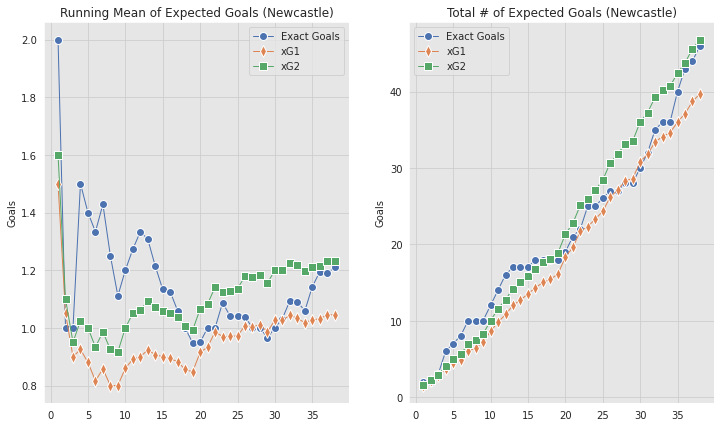

In [ ]:
 # not quite sure what "randomly selected football team" exactly means, so I have decided to let the randomizer pick a team 
def xG_plot(df):
    """
    Plots xG1, xG2  and exact number of goals scored by a randomly selected football team for whole 38 game weeks
    as well as running means of those three variables.

    Parameters
    ----------
    df : Pandas DATAFRAME
        dataframe that contains data from each football match, including, but not limited to columns "HS", "HST", "AS" and "AST".

    Returns
    -------
    dictionary
        contains calculated xGs for the randomly selected team as well as team's name

    """
    count = 0 # count for the while loop
    team = df.AwayTeam[np.random.randint(0,379)] # let the randomizer pick a random team and assign this team's name to a variable team
    goals_by_gameweek = list() # create a list goals_by_gameweek
    xgoals1_by_gameweek = list() # create a list xgoals1_by_gameweek
    xgoals2_by_gameweek = list() # create a list xgoals2_by_gameweek
    running_mean_goals = list() # create a list running_mean_goals
    running_mean_xgoals1 = list() # create a list running_mean_xgoals1
    running_mean_xgoals2 = list() # create a list running_mean_xgoals2
    while count < len(df.HomeTeam): # iterate through "HomeTeam" column
      if df.HomeTeam[count] == team: # if a captured team's name in column "HomeTeam" is the same as the team that we randomly picked
          goals_by_gameweek.append(df.FTHG[count]) # add its full time home goals to a list goals_by_gameweek
          xgoals1_by_gameweek.append(0.1*df.HS[count]) # add its (home team shots*0.1) to a list xgoals1_by_gameweek
          xgoals2_by_gameweek.append(0.1*df.HS[count]+0.05*df.HST[count]) # add its (home team shots*0.1 + home team shots on target*0.05) to a list xgoals2_by_gameweek
          count += 1 # add 1 to a count to continue an iteration process
      elif df.AwayTeam[count] == team: # if a captured team's name in column "AwayTeam" is the same as the team that we randomly picked
          goals_by_gameweek.append(df.FTAG[count]) # add its full time away goals to a list goals_by_gameweek
          xgoals1_by_gameweek.append(0.1*df.AS[count]) # add its (away team shots*0.1) to a list xgoals1_by_gameweek
          xgoals2_by_gameweek.append(0.1*df.AS[count]+0.05*df.AST[count]) # add its (away team shots*0.1 + away team shots on target*0.05) to a list xgoals2_by_gameweek
          count += 1 # add 1 to a count to continue an iteration process
      else: # if our randomly picked team's name isn't in any of those two columns
          count += 1 # add 1 to a count to continue an iteration process
    count = 1 # assign a value of 1 to a count for the while loop
    running_mean_goals.append(goals_by_gameweek[0]) # add the number of goals the team scored during the first gameweek to a list running_mean_goals
    running_mean_xgoals1.append(xgoals1_by_gameweek[0]) # add xG1 value that the team managed to obtain during the first gameweek to a list running_mean_xgoals1
    running_mean_xgoals2.append(xgoals2_by_gameweek[0]) # add xG2 value that the team managed to obtain during the first gameweek to a list running_mean_xgoals2
    while count < len(goals_by_gameweek): # iterate through a list goals_by_gameweek
      running_mean_goals.append(sum(goals_by_gameweek[:count+1])/(count+1)) # calculate and add the running mean of exact goals to a list running_mean_goals
      running_mean_xgoals1.append(sum(xgoals1_by_gameweek[:count+1])/(count+1)) # calculate and add the running mean of xG1 to a list running_mean_xgoals1
      running_mean_xgoals2.append(sum(xgoals2_by_gameweek[:count+1])/(count+1)) # calculate and add the running mean of xG2 to a list running_mean_xgoals2
      count += 1 # add 1 to a count to continue an iteration process
    gameweeks = list(range(1,39)) # create a list containing a number of each gameweek
    plt.figure(figsize=(12,7)) # set plot's size
    ax0 = plt.subplot(1, 2, 1) # divide a single plot into 2 subplots and let ax0 be the first subplot
    ax1 = plt.subplot(1, 2, 2) # divide a single plot into 2 subplots and let ax1 be the second sublot
    ax1.plot(gameweeks,np.cumsum(goals_by_gameweek), "-o", linewidth = 1, markersize = 8, markeredgecolor = "w") # set parameters for the second subplot's exact goals line
    ax1.plot(gameweeks,np.cumsum(xgoals1_by_gameweek), "-d", linewidth = 1, markersize = 8, markeredgecolor = "w") # set parameters for the second subplot's xG1 line
    ax1.plot(gameweeks,np.cumsum(xgoals2_by_gameweek), "-s", linewidth = 1, markersize = 8, markeredgecolor = "w") # set parameters for the second subplot's xG2 line
    ax1.legend(labels=["Exact Goals", "xG1", "xG2"]) # create a legend for the second subplot
    ax1.set_title("Total # of Expected Goals (" + team + ")") # set a title for the second subplot
    ax1.set_ylabel("Goals") # set the y-axis's label for the second subplot
    ax0.plot(gameweeks,running_mean_goals, "-o", linewidth = 1, markersize = 8, markeredgecolor = "w") # set parameters for the first subplot's running mean of exact goals line
    ax0.plot(gameweeks,running_mean_xgoals1, "-d", linewidth = 1, markersize = 8, markeredgecolor = "w") # set parameters for the first subplot's running mean of xG1 line
    ax0.plot(gameweeks,running_mean_xgoals2, "-s", linewidth = 1, markersize = 8, markeredgecolor = "w") # set parameters for the first subplot's running mean of xG2 line
    ax0.legend(labels=["Exact Goals", "xG1", "xG2"]) # create a legend for the first subplot
    ax0.set_title("Running Mean of Expected Goals (" + team + ")") # set a title for the first subplot
    ax0.set_ylabel("Goals") # set the y-axis's label for the first subplot
    plt.show() # show the plot
    xG1 = sum(xgoals1_by_gameweek) # let xG1 variable be a sum of all of the values of list xgoals1_by_gameweek
    xG2 = sum(xgoals2_by_gameweek) # let xG2 variable be a sum of all of the values of list xgoals2_by_gameweek
    return {team : (xG1, xG2)} # just for an example. your result might differ from this definition.
xG = xG_plot(df)

## P2.2 - Statistical Analysis (29 marks)

#### P2.2.1 - Model selection for Regression Analysis (9 marks)

In this question, we construct a regression analyses to investigate how well FTHG (or FTAG) can be predicted from the other variables in the dataframe. The objective of this question is to derive a sparse model (linear and polynomial) with fewer variables. 

#### P2.2.1.1 - Variable Selection for Linear Regression (5 marks)

In **variable selection** ('variable' means the same as 'predictor'), variables get iteratively added or removed from the regression model. Once finished, the model typically contains only a subset of the original variables. It makes it easier to interpret the model, and in some cases it makes it generalise better to new data. 

To perform variable selection, create a function `select_variable(df, main_pred, main_target, alpha)`, where 
 
 - `main_pred` is a dictionary of variables. For this analysis, firstly, either all Home or Away teams will be marked and the predictors given below will be used

  - Home: [Time, FTR, HTHG, HTR, HS, HST, HF, HC, HBP]
  
  - Away: [Time, FTR, HTAG, HTR, AS, AST, AF, AC, ABP]. 
 
 - `main_target` is the variable for the regression, Home: FTHG (or Away: FTAG)
 
 - `alpha` is the significance level for selecting significant predictors

The function should return

 - `main_pred` is the dictionary which stores the selected subset of initial `main_pred` both for home and away teams, in a format of `main_pred = {'Home': [... selected predictors here ...], 'Away': [... selected predictors here ...]}`.

To calculate regression fits and $p$-values you will use `statsmodels`. The general procedure follows two stages:

 - Stage 1 (adding predictors): you build a model by adding variables one after the other. You keep adding variables that increase the **adjusted $R^2$** value (provided by `statsmodels` package). 
  
  - Start with an empty set of variables
  
  - Fit multiple one-variable regression models. In each iteration, use one of the variables provided in predictors. The variable that leads to the largest increase in adjusted $R^2$ is added to the model.
  
  - Now proceed by adding a second variable into the model. Starting from the remaining variables, again choose the variable that leads to the largest increase in adjusted $R^2$.
  
  - Continue in the same way for the third, fourth, … variable.
  
  - You are finished when there is no variable left that increases adjusted $R^2$.
 
 - Stage 2 (removing non-significant predictors): if any of the utilised predictors are not significant, you need to remove them. Keep removing variables until all variables in the model are significant.

  - Start by fitting a model using the variables that have been added to the model in Stage 1.
  
  - If there is a variable that is not significant, remove the variable with the largest $p$-value and fit the model again with the reduced set of variables.
  
  - Keep removing variables and re-fitting the model until all remaining variables are significant.
  
  - The remaining significant variables are the output of your function.

In [ ]:
# Next three lines are for testing purposes
main_pred = {"Home": ["Time", "FTR", "HTHG", "HTR", "HS", "HST", "HF", "HC", "HBP"], "Away": ["Time", "FTR", "HTAG", "HTR", "AS", "AST", "AF", "AC", "ABP"]} 
main_target = {"Home": "FTHG", "Away": "FTAG"}
alpha = 0.05
def select_variable(df, main_pred, main_target, alpha):
  """
    Function generates a linear regression by firstly adding predictors one by one until there are no more predictors left in such pattern that R^2 is as high as it possibly can be.
    Then removes predictors which are not significant to the model, also one by one, starting from the one with the highest p-value, until only significant predictors are left.

    Parameters
    ----------
    df : Pandas DATAFRAME
        dataframe that contains data from each football match, including, but not limited to columns "Time", "FTR", "HTHG", "HTR", "HS", "HST", "HF", "HC", "HBP", "HTAG", "AS", "AST", "AF", "AC" and "ABP".
    main_pred : Dictionary
        Dictionary that contains predictors that may or may not be picked for the model fit
    main_target : Dictionary
        Dictionary that contains a target variable for the regression for both home and away teams
    alpha : Float
        DESCRIPTION.
        Constant that specifies a significance level for selecting significant predictors
    Returns
    -------
    main_pred : Dictionary
        Dictionary that consists of the selected subset of initial main_pred for both home and away teams

  """
  df['Time'] = df["Time"].astype('float64') # change the type of column "Time" to float
  df['FTR'] = df["FTR"].astype('float64') # change the type of column "FTR" to float
  df['HTR'] = df["HTR"].astype('float64') # change the type of column "HTR" to float
  x = list(main_pred.keys()) # create a list x that consists of all the keys from dictionary main_pred
  final_list = [] # create an empty list final_list
  count = 0 # count for the while loop
  while count < len(x): # interate through list x
    mylist = [] # let mylist be an empty list
    for n in main_pred[x[count]]: # iterate through values of the chosen key
      formula = main_target[x[count]]+"~"+n # create a formula for the fit that includes chosen value
      fit = sm.OLS.from_formula(formula, df).fit() # fit the model using the formula
      mylist.append([fit.rsquared, n]) # add model's R^2 and predictors used to fit the model to mylist
    one_var = max(mylist) # create a list one_var that containts maximum R^2 and its model's predictor(s)
    mylist = [] # let mylist be an empty list 
    for n in main_pred[x[count]]: # iterate through values of the chosen key
      formula = main_target[x[count]]+"~"+one_var[1]+"+"+n # create a formula for the fit that includes previous best performing predictor(s) and a chosen value
      fit = sm.OLS.from_formula(formula, df).fit() # fit the model using the formula
      mylist.append([fit.rsquared,one_var[1], n]) # add model's R^2 and predictors used to fit the model to mylist
    two_var = max(mylist) # create a list two_var that containts maximum R^2 and its model's predictor(s)
    mylist = [] # let mylist be an empty list
    for n in main_pred[x[count]]: # iterate through values of the chosen key
      formula = main_target[x[count]]+"~"+two_var[1]+"+"+two_var[2]+"+"+n # create a formula for the fit that includes previous best performing predictor(s) and a chosen value
      fit = sm.OLS.from_formula(formula, df).fit() # fit the model using the formula
      mylist.append([fit.rsquared,two_var[1],two_var[2],n]) # add model's R^2 and predictors used to fit the model to mylist
    three_var = max(mylist) # create a list three_var that containts maximum R^2 and its model's predictor(s)
    mylist = [] # let mylist be an empty list
    for n in main_pred[x[count]]: # iterate through values of the chosen key
      formula = main_target[x[count]]+"~"+three_var[1]+"+"+three_var[2]+"+"+three_var[3]+"+"+n # create a formula for the fit that includes previous best performing predictor(s) and a chosen value
      fit = sm.OLS.from_formula(formula, df).fit() # fit the model using the formula
      mylist.append([fit.rsquared,three_var[1],three_var[2],three_var[3],n]) # add model's R^2 and predictors used to fit the model to mylist
    four_var = max(mylist) # create a list four_var that containts maximum R^2 and its model's predictor(s)
    mylist = [] # let mylist be an empty list
    for n in main_pred[x[count]]: # iterate through values of the chosen key
      formula = main_target[x[count]]+"~"+four_var[1]+"+"+four_var[2]+"+"+four_var[3]+"+"+four_var[4]+"+"+n # create a formula for the fit that includes previous best performing predictor(s) and a chosen value
      fit = sm.OLS.from_formula(formula, df).fit() # fit the model using the formula
      mylist.append([fit.rsquared,four_var[1],four_var[2],four_var[3],four_var[4],n]) # add model's R^2 and predictors used to fit the model to mylist
    five_var = max(mylist) # create a list five_var that containts maximum R^2 and its model's predictor(s)
    mylist = [] # let mylist be an empty list
    for n in main_pred[x[count]]: # iterate through values of the chosen key
      formula = main_target[x[count]]+"~"+five_var[1]+"+"+five_var[2]+"+"+five_var[3]+"+"+five_var[4]+"+"+five_var[5]+"+"+n # create a formula for the fit that includes previous best performing predictor(s) and a chosen value
      fit = sm.OLS.from_formula(formula, df).fit() # fit the model using the formula
      mylist.append([fit.rsquared,five_var[1],five_var[2],five_var[3],five_var[4],five_var[5],n]) # add model's R^2 and predictors used to fit the model to mylist
    six_var = max(mylist) # create a list six_var that containts maximum R^2 and its model's predictor(s)
    mylist = [] # let mylist be an empty list
    for n in main_pred[x[count]]: # iterate through values of the chosen key
      formula = main_target[x[count]]+"~"+six_var[1]+"+"+six_var[2]+"+"+six_var[3]+"+"+six_var[4]+"+"+six_var[5]+"+"+six_var[6]+"+"+n # create a formula for the fit that includes previous best performing predictor(s) and a chosen value
      fit = sm.OLS.from_formula(formula, df).fit() # fit the model using the formula
      mylist.append([fit.rsquared,six_var[1],six_var[2],six_var[3],six_var[4],six_var[5],six_var[6],n]) # add model's R^2 and predictors used to fit the model to mylist
    sev_var = max(mylist) # create a list sev_var that containts maximum R^2 and its model's predictor(s)
    mylist = [] # let mylist be an empty list
    for n in main_pred[x[count]]: # iterate through values of the chosen key
      formula = main_target[x[count]]+"~"+sev_var[1]+"+"+sev_var[2]+"+"+sev_var[3]+"+"+sev_var[4]+"+"+sev_var[5]+"+"+sev_var[6]+"+"+sev_var[7]+"+"+n # create a formula for the fit that includes previous best performing predictor(s) and a chosen value
      fit = sm.OLS.from_formula(formula, df).fit() # fit the model using the formula
      mylist.append([fit.rsquared,sev_var[1],sev_var[2],sev_var[3],sev_var[4],sev_var[5],sev_var[6],sev_var[7],n]) # add model's R^2 and predictors used to fit the model to mylist
    eigh_var = max(mylist) # create a list eigh_var that containts maximum R^2 and its model's predictor(s)
    mylist = [] # let mylist be an empty list
    for n in main_pred[x[count]]: # iterate through values of the chosen key
      formula = main_target[x[count]]+"~"+eigh_var[1]+"+"+eigh_var[2]+"+"+eigh_var[3]+"+"+eigh_var[4]+"+"+eigh_var[5]+"+"+eigh_var[6]+"+"+eigh_var[7]+"+"+eigh_var[8]+"+"+n # create a formula for the fit that includes previous best performing predictor(s) and a chosen value
      fit = sm.OLS.from_formula(formula, df).fit() # fit the model using the formula
      mylist.append([fit.rsquared,eigh_var[1],eigh_var[2],eigh_var[3],eigh_var[4],eigh_var[5],eigh_var[6],eigh_var[7],eigh_var[8],n]) # add model's R^2 and predictors used to fit the model to mylist
    all_var = max(mylist) # create a list all_var that containts predictors of the best performing model so far
    formula = main_target[x[count]]+"~"+all_var[1]+"+"+all_var[2]+"+"+all_var[3]+"+"+all_var[4]+"+"+all_var[5]+"+"+all_var[6]+"+"+all_var[7]+"+"+all_var[8]+"+"+all_var[9] # create a formula for the fit that includes previous best performing predictors
    fit = sm.OLS.from_formula(formula, df).fit() # fit the model using the formula
    while max(fit.pvalues) > alpha: # maximum p-value is greater than alpha
      try: # try to remove the predictor with a captured p-value
        all_var.remove(fit.pvalues[fit.pvalues == max(fit.pvalues)].index[0]) # remove the predictor with a captured p-value from the list all_var
        formula = main_target[x[count]]+"~" # create an inital formula template with a target in it
        intCount = 1 # internal count for the internal while loop
        while intCount < len(all_var): # iterate through all_var list
          if intCount == 1: # if it's a first predictor in all_var
            formula += all_var[intCount] # add it straight to the formula
            intCount += 1 # add 1 to intCount to continue an iteration process
          else: # if it's not a first predictor in all_var
            formula += "+"+all_var[intCount] # add "+" and a predictor to the formula
            intCount += 1 # add 1 to intCount to continue an iteration process
        fit = sm.OLS.from_formula(formula, df).fit() # fit the model using the formula
      except: # if we can't remove a predictor from all_var, it probably means we hit an Intercept which is not a variable among predictors
        break # hence break the loop
    all_var.remove(all_var[0]) # remove R^2 from the list all_var
    final_list.append([x[count],all_var]) # add best performing/significant predictors for this key to final_list list
    count += 1 # add 1 to a count to continue an iteration process
  main_pred = {} # create a dictionary main_pred
  main_pred[final_list[0][0]] = final_list[0][1] # create a key and its value and add it to the dictionary main_pred
  main_pred[final_list[1][0]] = final_list[1][1] # create a key and its value and add it to the dictionary main_pred
  return main_pred
main_pred = select_variable(df,main_pred,main_target,alpha)
print(main_pred)

{'Home': ['HTHG', 'HST', 'FTR', 'HTR', 'HC'], 'Away': ['HTAG', 'FTR', 'AST', 'HTR']}


#### P2.2.1.2 - Model Selection for Polynomial Regression (4 marks)

Often the dataset provided is not linearly separable and a simple linear regression model may not be able to derive relationships between both the independent and dependent variables. In such cases, a possible solution would be to implement polynomial regression instead (https://en.wikipedia.org/wiki/Polynomial_regression). Polynomial regression is a form of regression analysis in which the relationship between the independent variable $x$ and the dependent variable $y$ is modelled as an $n^{th}$ degree polynomial in $x$.

**Example:** Given $y$ the dependent variable, $x_1, x_2$ the independent variables, $b_0$ the bias and $b_1,b_2,...,b_n$ the weights a polynomial regression of degree 2 would have the form:

$$y = b_0 + b_1x_1 + b_2x_1^2 + b_3x_2 + b_4x_2^2$$

Implement a function `polynomial_model(df, main_pred, main_target, degrees)` which uses the selected subset of variables as an argument from the function `select_variable()`, and calculates all possible combinations of the variable set and polynomial degrees. The function `polynomial_model()` finds the degree that yields the best polynomial model (according to the adjusted R-squared metric) to predict the value of a FTHG or FTAG as in the linear regression part above.

Arguments and outputs of the function are given as

 - a dataframe `df`, 

 - a dictionary `main_pred` indicating the predictors for home and away, 
 
 - a dictionary `main_target` indicating target variable for home and away, 
 
 - a list of integers indicating the degrees to test degrees, 
 
The function should return 

 - the best fitted regression model, and best polynomial degree for home and away in a dictionary `main_predp` of format `main_predp = {'Home': (best_fit, best_degree), 'Away': (best_fit, best_degree)}`..

In [ ]:
def polynomial_model(df, main_pred, main_target, degrees):
    """
    Function uses the selected subset of variables as an argument from the function select_variable(), and calculates all possible combinations of the variable set and polynomial degrees. The function also finds the degree that yields the best polynomial model

    Parameters
    ----------
    df : Pandas DATAFRAME
        dataframe that contains data from each football match, including, but not limited to columns "Time", "FTR", "HTHG", "HTR", "HS", "HST", "HF", "HC", "HBP", "HTAG", "AS", "AST", "AF", "AC" and "ABP".
    main_pred : Dictionary
        Dictionary that contains predictors that may or may not be picked for the model fit
    main_target : Dictionary
        Dictionary that contains a target variable for the regression for both home and away teams
    degrees : list
        List of polynomial degrees that are going to be tested

    Returns
    -------
    main_predp : Dictionary
        Dictionary that contrains the best fit for the regression model as well as it's degree for both home and away matches

    """
    main_predp = {} # let main_predp be an empty dictionary
    for n in main_target: # iterate through keys of the target variable
      count = 0 # count for the while loop
      main_target_key = main_target[n] # let a variable main_target_key be a chosen key from main_target
      main_pred_key = main_pred[n] # let a variable main_pred_key be a chosen key from main_pred
      degrees = degrees # let a variable degrees be equal to an input variable degrees
      rsquared_list = list() # let rsquared_list be an empty list
      variables = "" # let variables be an empty string
      prv_rsquared_adj = 0 # let a variable prv_rsquared_adj be equal to 0
      while count < (len(degrees)): # iterate through all the possible values of a list degrees
        for i in main_pred_key: # iterate through values of main_pred_keys
          poly_prep = ["I("+i+"**"+str(count+1)+")"] # add power to a chosen value of main_pred_keys
          variables = " + ".join(poly_prep)+" + "+variables # start preparing a formula for a fit
          poly_formula = main_target_key+"~"+variables[0:-2] # finish preparing a formula for a fit
          fit = sm.OLS.from_formula(poly_formula, df).fit() # fit the model with a formula
          rsquared_adj = fit.rsquared_adj # let a variable rsquared_adj be equal to model's adjusted r squared value
          rsquared_list.append(rsquared_adj) # add a variable rsquared_adj to a list of all the values of adjusted r squares
          if rsquared_adj > prv_rsquared_adj: # if a newly assigned variable rsquared_adj is larger than prv_rsquared_adj
            best_fit = poly_formula # let a variable best_fit hold a value of a variable poly_formula
            best_degree = count+1 # let a varible best_degree hold a number of degree of a polynomial
          prv_rsquared_adj = rsquared_adj # change a value of prv_rsquared_adj to a newly created value of a variable rsquared_adj
        count += 1 # add 1 to a variable count to continue an iteration process
      main_predp.update({n: (best_fit, best_degree)}) # update a dictionary main_predp with the best fit and the best degree
    return main_predp
# Next lines are for testing purposes
degrees = [1,2,3,4,5,6,7,8,9,10]
main_predp = polynomial_model(df, main_pred, main_target, degrees)
print(main_predp)

{'Home': ('FTHG~I(HTR**10) + I(FTR**10) + I(HST**10) + I(HTHG**10) + I(HC**9) + I(HTR**9) + I(FTR**9) + I(HST**9) + I(HTHG**9) + I(HC**8) + I(HTR**8) + I(FTR**8) + I(HST**8) + I(HTHG**8) + I(HC**7) + I(HTR**7) + I(FTR**7) + I(HST**7) + I(HTHG**7) + I(HC**6) + I(HTR**6) + I(FTR**6) + I(HST**6) + I(HTHG**6) + I(HC**5) + I(HTR**5) + I(FTR**5) + I(HST**5) + I(HTHG**5) + I(HC**4) + I(HTR**4) + I(FTR**4) + I(HST**4) + I(HTHG**4) + I(HC**3) + I(HTR**3) + I(FTR**3) + I(HST**3) + I(HTHG**3) + I(HC**2) + I(HTR**2) + I(FTR**2) + I(HST**2) + I(HTHG**2) + I(HC**1) + I(HTR**1) + I(FTR**1) + I(HST**1) + I(HTHG**1) ', 10), 'Away': ('FTAG~I(FTR**10) + I(HTAG**10) + I(HTR**9) + I(AST**9) + I(FTR**9) + I(HTAG**9) + I(HTR**8) + I(AST**8) + I(FTR**8) + I(HTAG**8) + I(HTR**7) + I(AST**7) + I(FTR**7) + I(HTAG**7) + I(HTR**6) + I(AST**6) + I(FTR**6) + I(HTAG**6) + I(HTR**5) + I(AST**5) + I(FTR**5) + I(HTAG**5) + I(HTR**4) + I(AST**4) + I(FTR**4) + I(HTAG**4) + I(HTR**3) + I(AST**3) + I(FTR**3) + I(HTAG**3) + 

#### P2.2.2 - Predicting Match Result (5 marks)


Create a function `predict_result()` which predicts the result of **Man City - Everton** football match which was played on 23/05/2021. In order to do this, firstly crop last last 10 rows of the data frame `df` to use only the first 37 weeks (370 matches) of the season to fit your regressors.

The function `predict_result()` will use `select_variable()` and `polynomial_model()` function outputs as the best linear and polynomial regression models. Then by using these two models, it predicts the number of goals scored by Home and Away teams separately, which will lead to the result of the match. Finally, print the information below:

```
Linear regression prediction        : Man City x - y Everton
Polynomial regression prediction    : Man City a - b Everton
Correct result                      : Man City 5 - 0 Everton
```

In [ ]:
def predict_result(df, main_pred, main_predp):
  """
    Function predicts the result of the Man City vs Everton game using Linear regression prediction and Polynomial regression prediction

    Parameters
    ----------
    df : Pandas DATAFRAME
        original dataframe
    main_pred : Dictionary
        Dictionary that contains predictors for the linear regression model fit
    main_predp : Dictionary
        Dictionary that contrains the best fit for the regression model as well as it's degree for both home and away matches

    Returns
    -------
    None.

  """
  new_df = df.copy() # copy an original dataframe and store it in a variable new_df, so we can edit it without editing the original dataframe
  new_df.drop(new_df.tail(10).index,inplace=True) # drop the last 10 rows of the dataframe
  match = df.iloc[[376]] # locate a game we need to predict a result for
  home_lin_formula = "FTHG ~ " + " + ".join(main_pred["Home"]) # store the best performing linear regression model's formula for a home team into a variable home_lin_formula
  fit = sm.OLS.from_formula(home_lin_formula, new_df).fit() # fit the formula into a model
  pred_home_lin_formula = round(fit.predict(match)) # predict the number of home team's goals
  home_poly_formula = main_predp["Home"][0] #  store the best performing polynomial regression model's formula for a home team into a variable home_poly_formula
  fit = sm.OLS.from_formula(home_poly_formula, new_df).fit() # fit the formula into a model
  pred_home_poly_formula = round(fit.predict(match)) # predict the number of home team's goals
  away_lin_formula = "FTAG ~ " + " + ".join(main_pred["Away"]) # store the best performing linear regression model's formula for an away team into a variable away_lin_formula
  fit = sm.OLS.from_formula(away_lin_formula, new_df).fit() # fit the formula into a model
  pred_away_lin_formula = round(fit.predict(match)) # predict the number of away team's goals
  away_poly_formula = main_predp["Away"][0] #  store the best performing polynomial regression model's formula for an away team into a variable away_poly_formula
  fit = sm.OLS.from_formula(away_poly_formula, new_df).fit() # fit the formula into a model
  pred_away_poly_formula = round(fit.predict(match)) # predict the number of away team's goals
  print("Linear regression prediction        : Man City " + str(int(pred_home_lin_formula)) + " - " + str(int(pred_away_lin_formula)) + " Everton") # print a prediction of the linear regression model
  print("Polynomial regression prediction    : Man City " + str(int(pred_home_poly_formula)) + " - " + str(int(pred_away_poly_formula)) + " Everton") # print a prediction of the polynomial regression model
  print("Correct result                      : Man City 5 - 0 Everton") # print an actual result of the game


predict_result(df, main_pred, main_predp)


Linear regression prediction        : Man City 4 - 0 Everton
Polynomial regression prediction    : Man City 4 - 0 Everton
Correct result                      : Man City 5 - 0 Everton


#### P2.2.3 - Maximum likelihood estimation (MLE) and prediction (10 marks)

In this question, you are expected to solve a regression problem, but this time using **maximum likelihood estimation (MLE)** theory. You need to construct a regression analysis to investigate how well the **full time results (FTR)** can be predicted from the other variables of FTHG, HS, HC, AS, AC. 

#### P2.2.3.1 - ML Estimate of regression parameters (7 marks)

Create a function `ML_estimate(df_est, pred, target)` which calculates the ordinary least squares (OLS) and two MLE fits (Poisson and Probit) for the given arguments.

You need to use `statsmodels` module and its corresponding methods of `.OLS()`, `.Poisson()` and `.Probit()`.

- `df_est` is a subset of the data frame `df` which includes **randomly selected** 280 rows of `df`. The remaining 100 rows will be used in prediction application (see below).

- `pred` is a list of variables. For this analysis, OLS and other models utilise the predictors of FTHG, HS, HC, AS, AC. (Note: Depending on your implementation, you might need to add a constant to the predictors. Please see the lecture notes)

- `target` is the target variable for the regression, FTR. You need to adjust values of this column for the purpose of this question. 
 
  - FTR = 1.0 if Home team wins.
  
  - FTR = 0.0 if Away team wins or a Draw.

The function should return variables 

 - `MLE_model_fits` a `tuple` object which stores all three model fits `statsmodels` objects for OLS, Probit and Poisson.

In [ ]:
# Data Preprocessing
pred = ["FTHG", "HS", "HC", "AS", "AC"] # let a variable pred be a list of predictors
target = ["FTR"] # let a variable target be a list of targets
count = 0 # count for the while loop
while count < len(df.FTR): # iterate through a column "FTR"
  if df.FTR[count] == -1.0: # if a captured value in a column "FTR" is equal to -1.0
    df.FTR[count] = 0.0 # reinitialize a captured value with a value 0.0
  count += 1 # add 1 to a variable count to continue an iteration process
df_est = df.copy() # copy an original dataframe and store it in a variable df_est, so we can edit it without editing the original dataframe
df_est.drop(df_est.columns.difference(target + pred), 1, inplace=True) # update dataframe and leave only columns "FTHG", "HS", "HC", "AS", "AC" and "FTR"
df_est["constant"] = 1 # adding a constant to the predictors
row, col = df_est.shape # let a variable row be the number of rows and a variable col be the number of columns in the dataframe df_est
train = np.random.choice(row, 280, replace = False) # randomly select 280 rows for the train set
test = np.setdiff1d(np.arange(row), train, assume_unique = True) # pick other 100 rows of the dataframe to be our test set
def ML_estimate(df_est, pred, target):
  """
    Function calculates the ordinary least squares (OLS) and two MLE fits (Poisson and Probit) for the given arguments.

    Parameters
    ----------
    df_est : Pandas DATAFRAME
        Preprocessed subset of an original df dataframe
    pred : List
        List of predictors
    target : List
        List of targets for the model fit. In this case just one target variable

    Returns
    -------
    MLE_model_fits : Tuple
        A tuple that stores all three model fits : OLS, Probit and Poisson

  """
  pred = df_est.iloc[train][pred] # extract predictors from the train set
  target = df_est.iloc[train][target[0]] # extract target from the train set
  fit_ols = sm.OLS(target, pred).fit() # fit OLS model
  fit_probit = sm.Probit(target, pred).fit() # fit Probit model
  fit_poiss = sm.Poisson(target, pred).fit() # fit Poisson model
  MLE_model_fits = (fit_ols, fit_probit, fit_poiss) # tuple required as an output containing model fits of OLS, Probit and Poisson
  return MLE_model_fits
MLE_model_fits = ML_estimate(df_est, pred, target)

Optimization terminated successfully.
         Current function value: 0.371288
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.661196
         Iterations 6


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  # Remove the CWD from sys.path while we load stuff.


#### P2.2.3.2 - Predicting Home Win via MLE (3 marks)

Create a function `ML_predict(df_pred, MLE_model_fits)` which calculates FTR predictions for all three models of OLS, Probit and Poisson.

You need to use `statsmodels`' method for prediction: `.predict()`.

- `df_pred` is a subset of the data frame `df` which includes only a subset of 100 rows of `df`.

- `MLE_model_fits` is a `tuple` object obtained from the `ML_estimate()` function above. Unpack this argument to obtain `statsmodels` objects for all three models. 

This function should return: 

 - `df_pred`

 - `MLE_model_predictions` is a `tuple` which stores the predicted outputs for each three models.  

In [ ]:
pred = ["FTHG", "HS", "HC", "AS", "AC"] # let a variable pred be a list of predictors
df_pred = df_est.iloc[test][pred] # extract predictors from the test set
def ML_predict(df_pred, MLE_model_fits):
  """
    Function calculates FTR predictions for all three models of OLS, Probit and Poisson

    Parameters
    ----------
    df_pred : Pandas DATAFRAME
        Preprocessed subset of an original df dataframe
    MLE_model_fits : Tuple
        A tuple that stores all three model fits : OLS, Probit and Poisson

    Returns
    -------
    df_pred : Pandas DATAFRAME
        Preprocessed subset of an original df dataframe
    MLE_model_predictions : Tuple
        Tuple which stores the predicted outputs for each three models

  """
  fit_ols = MLE_model_fits[0] # fit an OLS model
  fit_probit = MLE_model_fits[1] # fit a Probit model
  fit_poiss = MLE_model_fits[2] # fit a Poisson model
  preds_ols = fit_ols.predict(df_pred) # predictions by an OLS model
  preds_probit = fit_probit.predict(df_pred) # predictions by the Probit model
  preds_poiss = fit_poiss.predict(df_pred) # predictions by the Poisson model
  MLE_model_predictions = (preds_ols, preds_probit, preds_poiss) # tuple required as an output containing model fits of OLS, Probit and Poisson
  return df_pred, MLE_model_predictions
df_pred, MLE_model_predictions = ML_predict(df_pred, MLE_model_fits)[0], ML_predict(df_pred, MLE_model_fits)[1]

#### P2.2.4 - Evaluating Prediction Performance (5 marks)

You will now need to visualise the prediction performance of the models, and evaluate them in terms of prediction accuracy, and mean square error (MSE) metrics. For this purpose, create a function `prediction_perf(gt, MLE_model_predictions)` which evaluates the prediction performance of the reference models. Up to this point, you should have obtained

 - $N = 100$ samples of predictions from each model, stored in `MLE_model_predictions`.
 
 - The ground-truth FTR values from data frames `df`, stored in `gt`.

Assume predicted values for a given model are stored in a variable $P$ and its average is $\bar{P}$. The first performance measure will be the MSE, and will be calculated for each model from the expression below:

$$ MSE = \dfrac{1}{N}\sum_{i=0}^{N-1} (P_i - FTR_i)^2$$

In order to obtain the prediction accuracy for each model, you first should convert continuous prediction results into the binary form (either 1.0 or 0.0). The binarisation process will follow the piecewise function below:

  $$P_{binary, i} = \begin{cases} 1.0, & P_i \geq \bar{P}\\ 0.0, & \text{otherwise}  \end{cases} \quad \text{where} \quad i = 0, 1, \dots, 99$$

Then the percentage accuracy, $Acc\%$ is calculated as

$$ Acc\% = 100 - \sum_{i=0}^{99} |P_{binary, i} - FTR_i|$$

Following these, by using `sklearn` module methods `roc_curve()` and `auc()` find ROC curve parameters and AUC metric for each prediction model. 

In order to obtain performance analysis results in a neatly way, you then need to create a new `pandas` dataframe `df_results` which will be in the form of

```
+----+-------------+--------+--------+-------+
|    | Model       |   Acc% |    MSE |   AUC |
+====+=============+========+========+=======+
|  0 | OLS         |  77.00 | 0.1260 | 0.911 |
+----+-------------+--------+--------+-------+
|  1 | MLE-Probit  |  81.00 | 0.1086 | 0.911 |
+----+-------------+--------+--------+-------+
|  2 | MLE-Poisson |  76.00 | 0.1490 | 0.884 |
+----+-------------+--------+--------+-------+
```

Consequently, using `sklearn` method `RocCurveDisplay()`, the `prediction_perf()` function should 

 - `print` and `return` the data frame `df_results`.

**Marking for this question**
 - (2 marks) Calculating MSE and $Acc\%$ metrics correctly.
 - (3 marks) Creating and returning dataframe `df_results`.
 
with a condition that all these three operations are performed in a **fully working `prediction_perf()` function**.

+----+-------------+--------+--------+-------+
|    | Model       |   Acc% |    MSE |   AUC |
+====+=============+========+========+=======+
|  0 | OLS         |  86.00 | 0.1328 | 0.930 |
+----+-------------+--------+--------+-------+
|  1 | MLE-Probit  |  81.00 | 0.1056 | 0.936 |
+----+-------------+--------+--------+-------+
|  2 | MLE-Poisson |  79.00 | 1.1959 | 0.884 |
+----+-------------+--------+--------+-------+


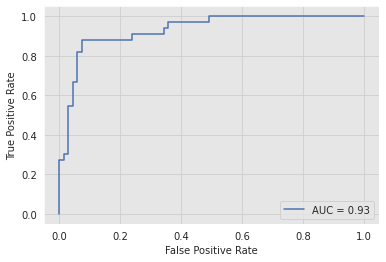

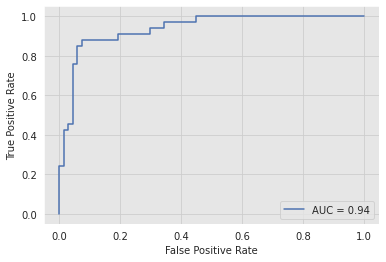

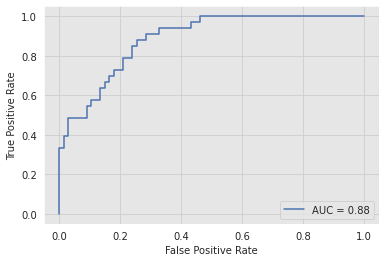

In [ ]:
def prediction_perf(gt, MLE_model_predictions):
  """
    Function evaluates the prediction performance of the reference models

    Parameters
    ----------
    gt : Series
        Series with float numbers representing correct FTR values
    MLE_model_predictions : Tuple
        Tuple which stores the predicted outputs for each three models

    Returns
    -------
    df_results : Pandas DATAFRAME
        Dataframe that stores performance analysis results

    """
  models = ["OLS", "MLE-Probit", "MLE-Poisson"] # creating a list of models' names
  count = 0 # count variable to use for the while loop
  intCount = 0 # internal count variable to use for the while loops within a while loop
  acc_list = list() # let acc_list be a list
  mse_list = list() # let mse_list be a list
  auc_list = list() # let auc_list be a list
  while count < len(models): # iterate through all of the models in the models list
    mse = 0 # let a variable mse be 0 for starters
    mle_list = list(MLE_model_predictions[count]) # let mle_list be a list containing predictions from the captured model
    gt_list = list(gt) # let gt_list be a list of series gt for an easier access during calculations
    while intCount < len(mle_list): # iterate through list mle_list
      mse += (1/len(MLE_model_predictions[count]))*(mle_list[intCount]-gt_list[intCount])**2 # using a formula from the task description calculate MSE of predictions from the captured model
      intCount += 1 # add 1 to an intCount variable to continue an iteration process
    mse_list.append(mse) # add the results to a list mse_list
    df_pred[target[0]] = gt # let a column "FTR" hold values from gt
    P_dash = MLE_model_predictions[count].mean() # calculate an average value of P of a captured model
    P_binary_list = list() # let P_binary_list be a list
    intCount = 0 # reset the value of a variable intCount to 0 to prepare for the next while loop
    while intCount < len(mle_list): # iterate through a list of predictions
      if mle_list[intCount] >= P_dash: # if a captured p value is larger or equal to an average of P
        P_binary_list.append(1) # add 1 to the list P_binary_list
      else: # if a captured p value is less than an average of P
        P_binary_list.append(0) # add 0 to the list P_binary_list
      intCount += 1 # add 1 to a variable intCount to continue an iteration process
    df_pred["P"] = mle_list # assign a list mle_list to a column P in df_pred dataframe
    df_pred["P_binary"] = P_binary_list # assign a list P_binary_list to a column P_binary in df_pred dataframe
    df_pred["Acc%"] = abs(df_pred.P_binary - df_pred.FTR) # calculate the accuracy using a formula from the task description
    acc = 100 - df_pred["Acc%"].sum() # assign 100 - sum of a column "Acc%" to a variable acc
    acc_list.append(acc) # add a variable acc to a list acc_list
    fpr, tpr, _ = roc_curve(df_pred.FTR, df_pred.P) # create a roc curve and assign its parameters to variables fpr, tpr and _
    roc_auc = auc(fpr, tpr) # find a value of an area under the curve using roc curve parameters and assign it to a variable roc_auc 
    auc_list.append(roc_auc) # add a value from above to the list auc_list
    roc_curve_disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc) # create a roc curve using parameters obtained in previous steps
    roc_curve_disp.plot() # plot the roc curve
    intCount = 0 # reset the value of a variable intCount to 0 to prepare for the next while loop
    count += 1 # add 1 to a variable count to continue an iteration process
  df_results = pd.DataFrame({"Model": models, "Acc%": acc_list, "MSE" : mse_list, "AUC": auc_list}) # creating a dataframe containing performance analysis results
  # Next lines are there to print df_results dataframe in a neatly way
  print("+----+-------------+--------+--------+-------+")
  print("|    | Model       |   Acc% |    MSE |   AUC |")
  print("+====+=============+========+========+=======+")
  print("|  {} | {}         |  {} | {} | {} |".format(str(0), df_results.Model[0], "{:.2f}".format(acc_list[0]), "{:.4f}".format(df_results.MSE[0]), "{:.3f}".format(df_results.AUC[0])))
  print("+----+-------------+--------+--------+-------+")
  print("|  {} | {}  |  {} | {} | {} |".format(str(1), df_results.Model[1], "{:.2f}".format(acc_list[1]), "{:.4f}".format(df_results.MSE[1]), "{:.3f}".format(df_results.AUC[1])))
  print("+----+-------------+--------+--------+-------+")
  print("|  {} | {} |  {} | {} | {} |".format(str(2), df_results.Model[2], "{:.2f}".format(acc_list[2]), "{:.4f}".format(df_results.MSE[2]), "{:.3f}".format(df_results.AUC[2])))
  print("+----+-------------+--------+--------+-------+")
  return df_results
gt = df.iloc[test][target[0]]
df_results = prediction_perf(gt, MLE_model_predictions)